# Setup, imports


In [1]:
# Add the parent directory to path
import sys

sys.path.append("..")


In [2]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

"""Policy imports"""
from utils.utils import simulate_policy

%matplotlib inline

In [3]:
!which python3

/Users/mohahf19/micromamba/envs/annrl2023/bin/python3


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


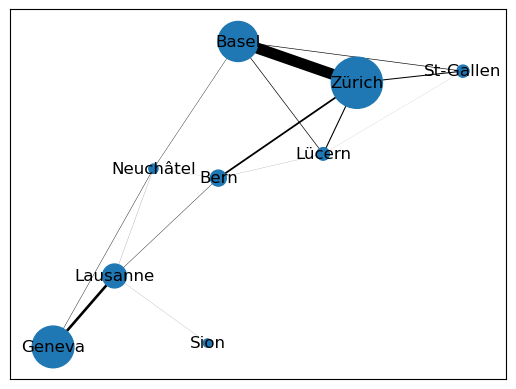

In [4]:
dyn = ModelDynamics("../config/switzerland.yaml")  # load the switzerland map
print(dyn.cities)
dyn.draw_map()


# Question 2.a


In [5]:
"""Loading the environment"""
env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=None,  # Here one could pass an openai gym action space that can then be sampled
    observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
)


In [6]:
action = {  # DO NOTHING
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}


In [7]:
# Set Russo strategy constants
CONFINEMENT_WEEKS = 4
INFECTED_THRESHOLD = 20000


In [8]:
class RussoAgent(Agent):
    def __init__(
        self,
        env: Env,
        # Additionnal parameters to be added here
    ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.curr_conf_week = 0

        self.policy_action = {
            "confinement": False,
            "isolation": False,
            "hospital": False,
            "vaccinate": False,
        }

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0

    def reset(
        self,
    ):
        # self.env.reset()
        # This should be called when the environment is reset
        self.curr_conf_week = 0

    def act(self, obs):
        if obs.total.infected[-1] > INFECTED_THRESHOLD and self.curr_conf_week == 0:
            self.policy_action["confinement"] = True
            self.curr_conf_week = 1
        elif 0 < self.curr_conf_week < CONFINEMENT_WEEKS:
            self.curr_conf_week += 1
        elif self.curr_conf_week == CONFINEMENT_WEEKS:
            self.policy_action["confinement"] = False
            self.curr_conf_week = 0

        return self.policy_action


In [9]:
russo_agent = RussoAgent(env)


In [10]:
def exec_russo_policy(n_weeks=30, simulation_seed=0):
    log = []
    curr_rewards = []

    # print(f"Sim seed = {simulation_seed}")
    _, _ = russo_agent.env.reset(simulation_seed)

    curr_policy = []

    russo_policy = {  # DO NOTHING
        "confinement": False,
        "isolation": False,
        "hospital": False,
        "vaccinate": False,
    }

    for i in range(n_weeks):
        obs, rew, finished, info = russo_agent.env.step(russo_policy)
        log.append(info)  # save the information dict for logging

        curr_policy.append(int(russo_policy["confinement"]))
        curr_rewards.append(rew)

        russo_policy = russo_agent.act(obs)

        if finished:
            break
    """ Parse the logs """
    tot = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cit = {
        c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters}
        for c in dyn.cities
    }
    act = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    # print(len(curr_policy))
    return tot, cit, act, curr_policy, curr_rewards


Text(0.5, 0, 'Weeks')

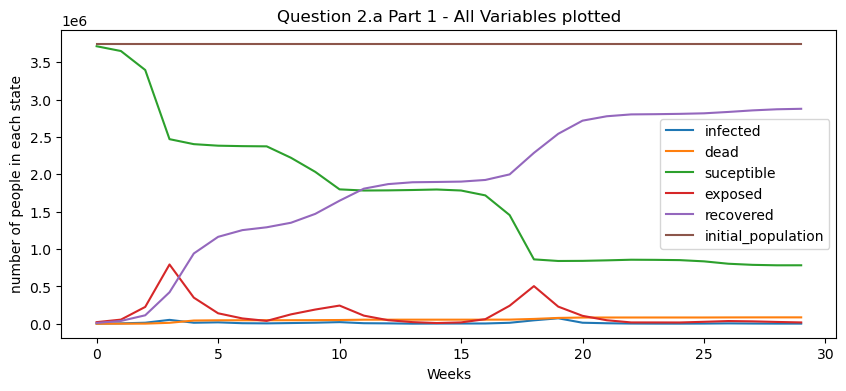

In [11]:
seed = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

""" Run the simulations, seeded"""

total, cities, actions, policy, _ = exec_russo_policy(n_weeks=30, simulation_seed=seed)


[ax.plot(y) for y in total.values()]
ax.legend(total.keys())
ax.set_title("Question 2.a Part 1 - All Variables plotted")
ax.set_ylabel("number of people in each state")
ax.set_xlabel("Weeks")


Text(0.5, 0, 'Weeks')

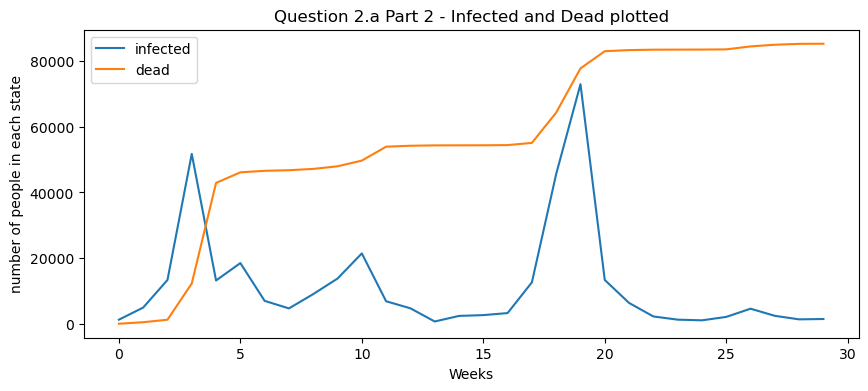

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

total_tmp = {"infected": total["infected"], "dead": total["dead"]}
[ax.plot(y) for y in total_tmp.values()]
ax.legend(total_tmp.keys())
ax.set_title("Question 2.a Part 2 - Infected and Dead plotted")
ax.set_ylabel("number of people in each state")
ax.set_xlabel("Weeks")


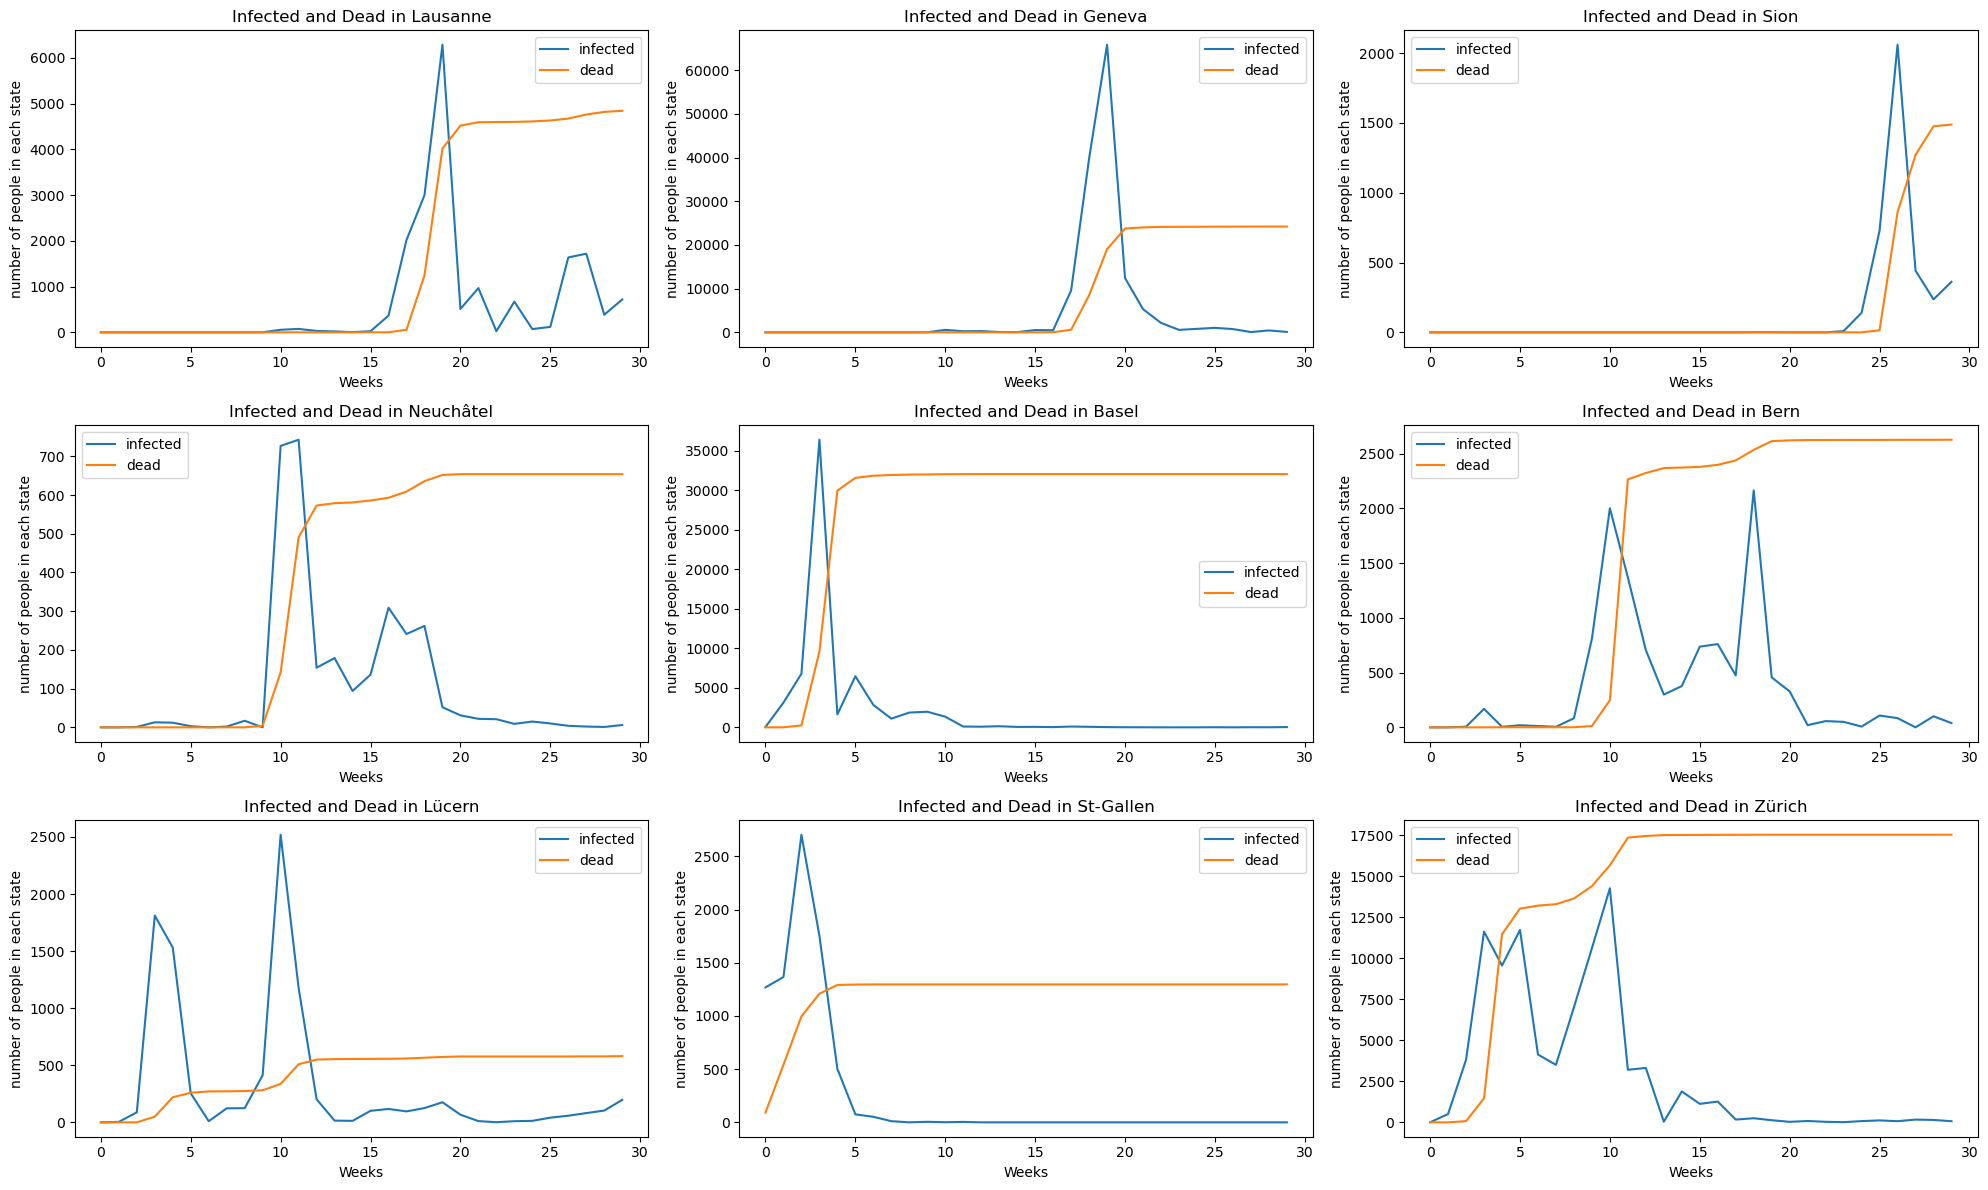

In [16]:
fig, ax = plt.subplots(3, 3,figsize=(20,12))

ax = ax.flatten()

for index, (city, city_total) in enumerate(cities.items()):

    total_tmp = {'infected':city_total['infected'], 'dead':city_total['dead']}
    [ax[index].plot(y) for y in total_tmp.values()]
    ax[index].legend(total_tmp.keys())
    ax[index].set_title(f"Infected and Dead in {city}")
    ax[index].set_ylabel('number of people in each state')
    ax[index].set_xlabel('Weeks')

fig.tight_layout()


Text(0.5, 0, 'Weeks')

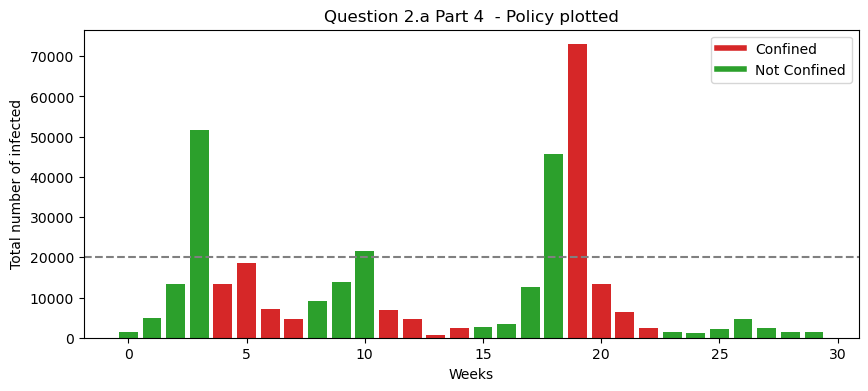

In [16]:
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="tab:red", lw=4),
    Line2D([0], [0], color="tab:green", lw=4),
]


fig, ax = plt.subplots(1, 1, figsize=(10, 4))

weeks = np.arange(len(policy))

colors = []

for i in range(len(policy)):
    if policy[i] == 1:
        colors.append("tab:red")
    else:
        colors.append("tab:green")

total_tmp = {"infected": total["infected"]}
[ax.bar(weeks, y, color=colors) for y in total_tmp.values()]

ax.axhline(y=INFECTED_THRESHOLD, color="gray", linestyle="--")
ax.legend(custom_lines, ["Confined", "Not Confined"])
ax.set_title("Question 2.a Part 4  - Policy plotted")
ax.set_ylabel("Total number of infected")
ax.set_xlabel("Weeks")


# Question 2.b


# Question 2.a


In [18]:
total_days_confined, total_dead, cumulative_rewards = simulate_policy(
    exec_russo_policy, n=50, seeds=np.arange(50)
)

In [19]:
# Print the mean and std
print(f"Mean total days confined: {np.mean(total_days_confined)}")
print(f"Std total days confined: {np.std(total_days_confined)}")
print(f"Mean total dead: {np.mean(total_dead)}")
print(f"Std total dead: {np.std(total_dead)}")
print(f"Mean cumulative rewards: {np.mean(cumulative_rewards)}")
print(f"Std cumulative rewards: {np.std(cumulative_rewards)}")


Mean total days confined: 100.52
Std total days confined: 16.070146234555555
Mean total dead: 58242.82
Std total dead: 19936.205613596587
Mean cumulative rewards: -69.95880126953125
Std cumulative rewards: 58.830360412597656


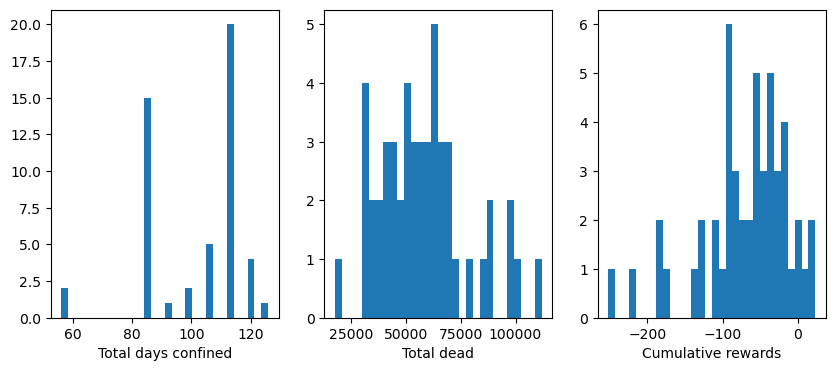

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].hist(total_days_confined, bins=30, label="total_confined")
ax[0].set_xlabel("Total days confined")

ax[1].hist(total_dead, bins=30, label="total_dead")
ax[1].set_xlabel("Total dead")

ax[2].hist(cumulative_rewards, bins=30, label="cumulative_rewards")
ax[2].set_xlabel("Cumulative rewards")

plt.show()
